In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
import numpy as np
import seaborn as sns
import os
import pyopa
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

In [5]:
# Load mmseqs2 easy-search results
mmseqs_search = pd.read_csv('../results/lost_proteins_best_hitst_to_bb.m8', sep='\t', header=None)
mmseqs_search.columns = ['query', 'target', 'identity', 'alignment_length', 'mismatches', 'gap_openings', 'q_start', 'q_end', 't_start', 't_end', 'e_value', 'bit_score']


In [14]:
crocosphera_seqs = SeqIO.parse('../data/crocosphaera_proteins.fasta', 'fasta')
crocosphera_seqs_dict = {seq.id: seq for seq in crocosphera_seqs}

bb_seqs = SeqIO.parse('../data/ADK1075_proteomics_DB_2.fasta', 'fasta')
bb_seqs_dict = {seq.id: seq for seq in bb_seqs}

In [19]:
crocosphera_seq_lens = {seq.id: len(seq.seq) for seq in crocosphera_seqs_dict.values()}
bb_seq_lens = {seq.id: len(seq.seq) for seq in bb_seqs_dict.values()}

In [10]:
mmseqs_search

,query,target,identity,alignment_length,mismatches,gap_openings,q_start,q_end,t_start,t_end,e_value,bit_score
0,WP_009543196.1,KC1-P2_N3_k31_Locus_4951_Transcript_4_1,0.287,87,61,0,119,205,240,326,3.225000e-06,49
1,WP_009543196.1,KC1-P2_N3_k31_Locus_9660_Transcript_1_1,0.242,138,96,0,75,202,434,571,5.522000e-05,46
2,WP_009543196.1,KC1-P2_N1_k25_Locus_22789_Transcript_1_1,0.291,79,53,0,130,205,132,210,4.010000e-04,43
3,WP_009543196.1,KC1-P2-N_k43_Locus_28391_Transcript_3_1,0.291,79,53,0,130,205,521,599,4.010000e-04,43
4,WP_243397361.1,KC1-P2_N3_k25_Locus_8601_Transcript_8_1,0.298,333,220,0,19,333,40,372,1.184000e-24,107
...,...,...,...,...,...,...,...,...,...,...,...,...
19552,WP_012362058.1,KC1-P2_N3_k65_Locus_6756_Transcript_1_1,0.231,350,238,0,1558,1868,85,434,4.130000e-05,50
19553,WP_012362058.1,KC1-P2_N1_k25_Locus_1613_Transcript_2_1,0.281,176,118,0,786,950,532,707,7.147000e-05,49
19554,WP_012362058.1,BDA39646.1,0.262,160,100,0,1558,1694,41,200,9.403000e-05,49
19555,WP_012362058.1,KC1-P2_N3_k43_Locus_28721_Transcript_1_1,0.257,173,108,0,1545,1690,12,184,2.141000e-04,48


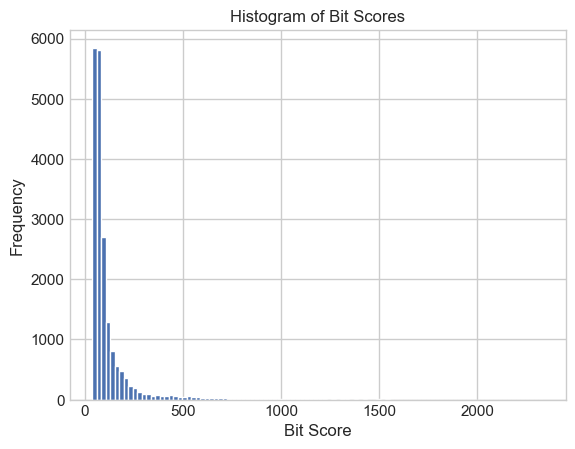

In [28]:
# Histogram of bit scores
plt.hist(mmseqs_search['bit_score'], bins=100)
plt.xlabel('Bit Score')
plt.ylabel('Frequency')
plt.title('Histogram of Bit Scores')
plt.show()

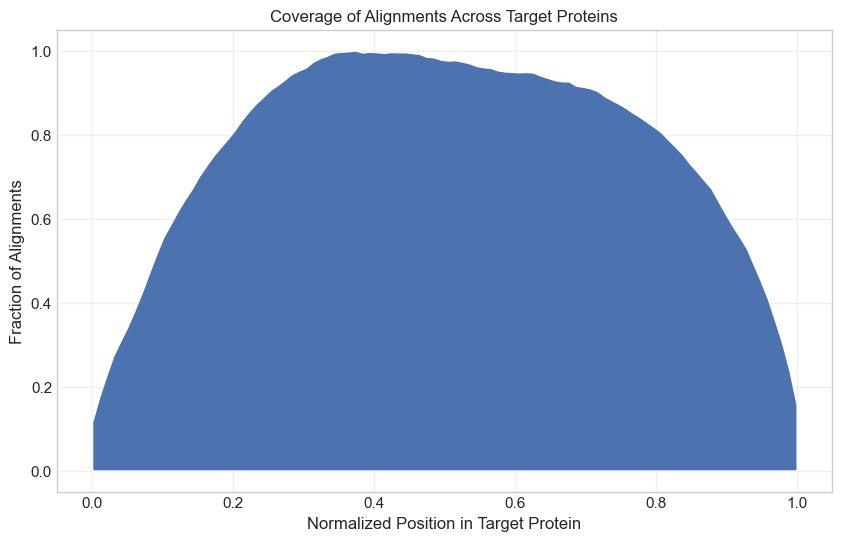

In [29]:
def plot_normalized_alignment_coverage(search_results, target_lengths):
    """
    Creates a coverage plot showing where alignments tend to occur on target proteins.
    
    Args:
        search_results: DataFrame with MMseqs2 results
        target_lengths: Dictionary mapping target IDs to their sequence lengths
    """
    # Create bins for normalized positions (100 bins from 0 to 1)
    bins = np.linspace(0, 1, 101)
    coverage = np.zeros(100)
    
    # Process each alignment
    for _, row in search_results.iterrows():
        target_id = row['target']
        target_length = target_lengths[target_id]
        
        # Normalize start and end positions
        norm_start = row['t_start'] / target_length
        norm_end = row['t_end'] / target_length
        
        # Find which bins this alignment covers
        start_bin = int(norm_start * 100)
        end_bin = int(norm_end * 100)
        
        # Increment coverage for all bins this alignment spans
        coverage[start_bin:end_bin+1] += 1
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.fill_between(np.linspace(0, 1, 100), coverage / coverage.max())
    plt.xlabel('Normalized Position in Target Protein')
    plt.ylabel('Fraction of Alignments')
    plt.title('Coverage of Alignments Across Target Proteins')
    plt.grid(True, alpha=0.3)
    plt.show()

# Use the function
plot_normalized_alignment_coverage(mmseqs_search, bb_seq_lens)

  0%|          | 0/4832 [00:00<?, ?it/s]

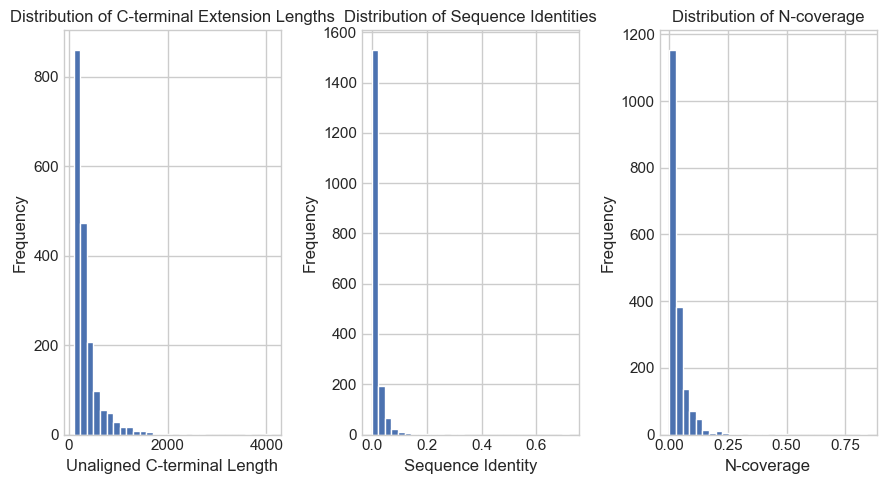

Found 1835 proteins with potential C-terminal extensions

Top 10 longest potential C-terminal extensions:
                                      target           query  target_length  \
5                    KC1-P2-N_CL101Contig2_1  WP_012362063.1           5876   
4                    KC1-P2-N_CL101Contig1_1  WP_009547778.1           4739   
390   KC1-P2-N_k31_Locus_1422_Transcript_8_1  WP_009547878.1           3964   
116                 KC1-P2-N_CL7806Contig1_1  WP_009547229.1           3724   
809   KC1-P2-N_k49_Locus_4536_Transcript_2_1  WP_009544137.1           2671   
1393  KC1-P2_N2_k55_Locus_403_Transcript_1_1  WP_009546945.1           2618   
1552  KC1-P2_N3_k37_Locus_163_Transcript_9_1  WP_009543395.1           2570   
1647  KC1-P2_N3_k69_Locus_842_Transcript_7_1  WP_009543644.1           2397   
790   KC1-P2-N_k49_Locus_2367_Transcript_8_1  WP_009547029.1           2407   
1569  KC1-P2_N3_k37_Locus_834_Transcript_6_1  WP_009547029.1           2368   

      unaligned_c_term  

In [52]:
def find_c_terminal_extensions(search_results, target_seqs_dict, query_seqs_dict, 
                             min_unaligned_c_term=100):
    """
    Find proteins with potential C-terminal extensions using PyOPA for accurate alignment.
    
    Args:
        search_results: DataFrame with MMseqs2 results
        target_seqs_dict: Dictionary of target BioPython sequences
        query_seqs_dict: Dictionary of query BioPython sequences
        min_unaligned_c_term: Minimum unaligned C-terminal length to consider
        min_identity: Minimum sequence identity for the aligned region
    """
    # Load default environments from PyOPA
    defaults = pyopa.load_default_environments()
    env = defaults['environments'][0]  # Use first available environment
    
    # Group by target to get best hit for each target protein
    best_hits = search_results.sort_values('bit_score', ascending=False).groupby('target').first().reset_index()
    
    results = []
    for _, row in tqdm(best_hits.iterrows(), total=len(best_hits)):
        target_id = row['target']
        query_id = row['query']
        
        target_seq = target_seqs_dict[target_id]
        query_seq = query_seqs_dict[query_id]
        
        # Calculate unaligned C-terminal length
        unaligned_c_term = len(target_seq.seq) - row['t_end']
        
        if unaligned_c_term >= min_unaligned_c_term:
            # Extract N-terminal region (excluding potential extension)
            target_n_term = str(target_seq.seq[:row['t_end']])
            
            # Create PyOPA sequence objects
            target_opa = pyopa.Sequence(target_n_term)
            query_opa = pyopa.Sequence(str(query_seq.seq))
            
            # Compute alignment score and get alignment strings
            aligned_strings = pyopa.align_strings(query_opa, target_opa, env, True)  # True for global alignment
            aligned_strings = [str(s) for s in aligned_strings]
            
            # Calculate identity from aligned strings
            matches = sum(1 for q, t in zip(aligned_strings[0], aligned_strings[1]) if q == t)
            identity = matches / len(aligned_strings[0])
            
            # Calculate what percentage of the target_n_term is aligned
            n_coverage = matches / len(target_n_term)
            
            results.append({
                'target': target_id,
                'query': query_id,
                'target_length': len(target_seq.seq),
                'unaligned_c_term': unaligned_c_term,
                'identity': identity,
                'aligned_length': len(aligned_strings[0]),
                'n-coverage': n_coverage
            })
    
    results_df = pd.DataFrame(results)
    
    # Create plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 5))
    
    # Plot distribution of unaligned C-terminal lengths
    ax1.hist(results_df['unaligned_c_term'], bins=30)
    ax1.set_xlabel('Unaligned C-terminal Length')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of C-terminal Extension Lengths')
    
    # Plot distribution of sequence identities
    ax2.hist(results_df['identity'], bins=30)
    ax2.set_xlabel('Sequence Identity')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Sequence Identities')
    
    # Plot distribution of n-coverage
    ax3.hist(results_df['n-coverage'], bins=30)
    ax3.set_xlabel('N-coverage')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of N-coverage')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Found {len(results_df)} proteins with potential C-terminal extensions")
    return results_df

# Use the function
extensions = find_c_terminal_extensions(
    mmseqs_search,
    bb_seqs_dict,
    crocosphera_seqs_dict,
    min_unaligned_c_term=100,
)

# Display the top results sorted by unaligned C-terminal length
print("\nTop 10 longest potential C-terminal extensions:")
print(extensions.sort_values('unaligned_c_term', ascending=False).head(10))

In [51]:
# how many results with n-coverage > 0.2
len(extensions[extensions['n-coverage'] > 0.2])

26

In [41]:
# save the results
extensions.to_csv('../results/lost_proteins_c_terminal_extensions.csv', index=False)


In [2]:
# load the results
extensions = pd.read_csv('../results/lost_proteins_c_terminal_extensions.csv')
extensions

,target,query,target_length,unaligned_c_term,identity,aligned_length
0,BDA39298.1,WP_009543784.1,519,125,0.014963,1203
1,BDA39669.1,WP_009543784.1,515,182,0.000863,1159
2,BDA39984.1,WP_009544170.1,630,262,0.009569,836
3,BDA40144.1,WP_009543825.1,524,116,0.005675,881
4,KC1-P2-N_CL101Contig1_1,WP_009547778.1,4739,3681,0.018315,3549
...,...,...,...,...,...,...
1830,SAG_S1_L001_R1_001_(paired)_co.g13,WP_009544954.1,422,221,0.132857,700
1831,SAG_S1_L001_R1_001_(paired)_co.g25,WP_009545344.1,1680,755,0.311828,1488
1832,SAG_S1_L001_R1_001_(paired)_co.g5,WP_009543893.1,615,472,0.209726,329
1833,SAG_S1_L001_R1_001_(paired)_co.g6,WP_009543881.1,523,148,0.142857,469


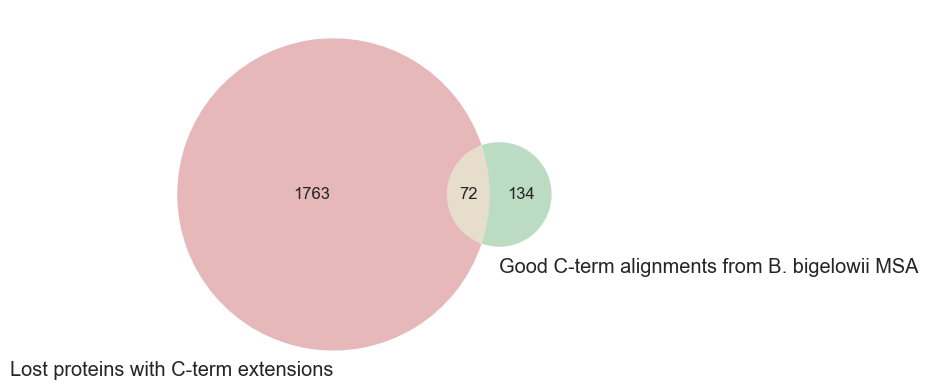

In [47]:
extension_ids = set(extensions['target'])

good_c_term = SeqIO.parse('../data/good-c-term-full.fasta', 'fasta')
good_c_term_ids = set([seq.id for seq in good_c_term])

import matplotlib_venn

matplotlib_venn.venn2([extension_ids, good_c_term_ids], ('Lost proteins with C-term extensions', 'Good C-term alignments from B. bigelowii MSA'))


In [53]:
# save bb seqs with good c-term
SeqIO.write([bb_seqs_dict[id] for id in extension_ids], '../results/c-term-extensions.fasta', 'fasta')

1835

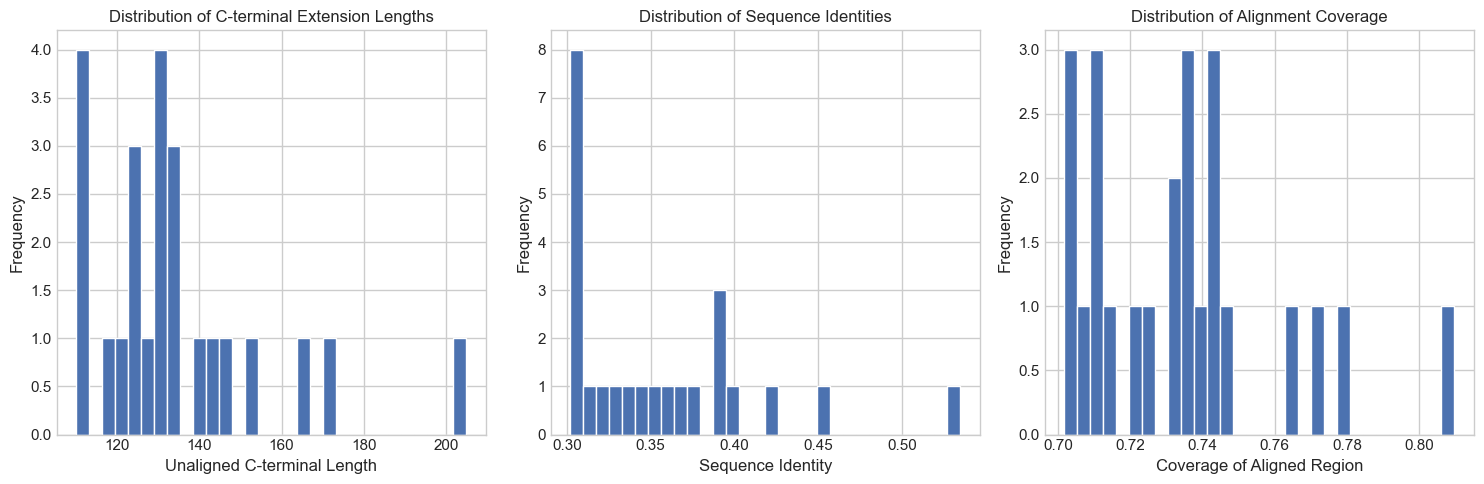

Found 24 proteins with potential C-terminal extensions

Top 10 longest potential C-terminal extensions:
                                     target           query  target_length  \
18                 KC1-P2_N3_CL452Contig1_1  WP_024750149.1            827   
8   KC1-P2-N_k43_Locus_13208_Transcript_1_1  WP_009546377.1            798   
7    KC1-P2-N_k37_Locus_8517_Transcript_4_1  WP_024750257.1            837   
4    KC1-P2-N_k31_Locus_1919_Transcript_3_1  WP_009545414.1            907   
3    KC1-P2-N_k31_Locus_1092_Transcript_7_1  WP_009547631.1            618   
13   KC1-P2-N_k49_Locus_7592_Transcript_3_1  WP_009545885.1            657   
12  KC1-P2-N_k49_Locus_16019_Transcript_1_1  WP_009544966.1            657   
0    KC1-P2-N_k25_Locus_2575_Transcript_1_1  WP_009547198.1            727   
11   KC1-P2-N_k43_Locus_9493_Transcript_2_1  WP_024750365.1            925   
5     KC1-P2-N_k31_Locus_212_Transcript_9_1  WP_009545602.1            547   

    unaligned_c_term  identity  cover

In [30]:
def find_c_terminal_extensions(search_results, target_lengths, min_unaligned_c_term=100, min_identity=0.3, min_coverage=0.7):
    """
    Find proteins with potential C-terminal extensions by identifying those where:
    1. The C-terminus has no alignment for at least min_unaligned_c_term amino acids
    2. The rest of the protein aligns well (based on identity and coverage thresholds)
    
    Args:
        search_results: DataFrame with MMseqs2 results
        target_lengths: Dictionary mapping target IDs to their sequence lengths
        min_unaligned_c_term: Minimum unaligned C-terminal length to consider
        min_identity: Minimum sequence identity for the aligned region
        min_coverage: Minimum coverage of the aligned region vs total query length
    
    Returns:
        DataFrame with filtered results and additional metrics
    """
    # Group by target to get best hit for each target protein
    best_hits = search_results.sort_values('bit_score', ascending=False).groupby('target').first().reset_index()
    
    # Calculate additional metrics
    results = []
    for _, row in best_hits.iterrows():
        target_id = row['target']
        target_length = target_lengths[target_id]
        
        # Calculate unaligned C-terminal length
        unaligned_c_term = target_length - row['t_end']
        
        # Calculate coverage of aligned region
        aligned_length = row['t_end'] - row['t_start']
        coverage = aligned_length / target_length
        
        if (unaligned_c_term >= min_unaligned_c_term and 
            row['identity'] >= min_identity and 
            coverage >= min_coverage):
            
            results.append({
                'target': target_id,
                'query': row['query'],
                'target_length': target_length,
                'unaligned_c_term': unaligned_c_term,
                'identity': row['identity'],
                'coverage': coverage,
                'bit_score': row['bit_score']
            })
    
    results_df = pd.DataFrame(results)
    
    # Create plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot distribution of unaligned C-terminal lengths
    ax1.hist(results_df['unaligned_c_term'], bins=30)
    ax1.set_xlabel('Unaligned C-terminal Length')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of C-terminal Extension Lengths')
    
    # Plot distribution of sequence identities
    ax2.hist(results_df['identity'], bins=30)
    ax2.set_xlabel('Sequence Identity')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Sequence Identities')
    
    # Plot distribution of coverage
    ax3.hist(results_df['coverage'], bins=30)
    ax3.set_xlabel('Coverage of Aligned Region')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Alignment Coverage')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Found {len(results_df)} proteins with potential C-terminal extensions")
    return results_df

# Use the function
extensions = find_c_terminal_extensions(
    mmseqs_search, 
    bb_seq_lens, 
    min_unaligned_c_term=100,
    min_identity=0.3,
    min_coverage=0.7
)

# Display the top results sorted by unaligned C-terminal length
print("\nTop 10 longest potential C-terminal extensions:")
print(extensions.sort_values('unaligned_c_term', ascending=False).head(10))

In [55]:
from Bio import SearchIO
from typing import Dict, List, Tuple
import os

def analyze_hmmer_basic(hmmer_out_path: str) -> Tuple[List[str], float]:
    """
    Basic function to parse HMMER output and return matching protein IDs.
    
    Args:
        hmmer_out_path: Path to the HMMER output file
    
    Returns:
        Tuple containing:
        - List of protein IDs that had matches
        - Percentage of proteins that matched
    """
    try:
        # Parse the HMMER output file
        hmmer_qresults = SearchIO.parse(hmmer_out_path, 'hmmer3-text')
        
        # Process each query result
        matching_ids = []
        total_proteins = 0
        
        for qresult in hmmer_qresults:
            # Count total proteins examined
            total_proteins = len(qresult.hits)
            
            # Get IDs of proteins with hits
            matching_ids = [hit.id for hit in qresult.hits]
        
        # Calculate percentage (avoid division by zero)
        percentage = (len(matching_ids) / total_proteins * 100) if total_proteins > 0 else 0
        
        return matching_ids, percentage
        
    except Exception as e:
        print(f"Error parsing HMMER output: {e}")
        return [], 0

def analyze_hmmer_detailed(hmmer_out_path: str, e_value_threshold: float = 1e-5) -> Dict:
    """
    Detailed function to parse HMMER output and analyze matches.
    
    Args:
        hmmer_out_path: Path to the HMMER output file
        e_value_threshold: E-value threshold for considering significant matches
    
    Returns:
        Dictionary containing analysis results
    """
    try:
        # Parse the HMMER output file
        hmmer_qresults = SearchIO.parse(hmmer_out_path, 'hmmer3-text')
        
        results = {
            'matching_ids': [],
            'total_proteins': 0,
            'significant_matches': [],  # matches below e-value threshold
            'match_details': [],        # detailed match information
            'percentage': 0.0,
            'significant_percentage': 0.0
        }
        
        for qresult in hmmer_qresults:
            results['total_proteins'] = len(qresult.hits)
            
            for hit in qresult.hits:
                # Store basic match information
                results['matching_ids'].append(hit.id)
                
                # Store detailed match information
                hit_info = {
                    'id': hit.id,
                    'e_value': hit.evalue,
                    'bitscore': hit.bitscore,
                    'domains': len(hit.hsps),
                    'significant': hit.evalue <= e_value_threshold
                }
                results['match_details'].append(hit_info)
                
                # Track significant matches
                if hit.evalue <= e_value_threshold:
                    results['significant_matches'].append(hit.id)
        
        # Calculate percentages
        if results['total_proteins'] > 0:
            results['percentage'] = len(results['matching_ids']) / results['total_proteins'] * 100
            results['significant_percentage'] = len(results['significant_matches']) / results['total_proteins'] * 100
        
        return results
        
    except Exception as e:
        print(f"Error parsing HMMER output: {e}")
        return {}


# Basic usage
matches, percentage = analyze_hmmer_basic("../hmm-out")
print(f"Found {len(matches)} matches ({percentage:.1f}%)")

# Detailed usage
results = analyze_hmmer_detailed("../hmm-out")
print(f"\nDetailed Analysis:")
print(f"Total proteins examined: {results['total_proteins']}")
print(f"Total matches: {len(results['matching_ids'])} ({results['percentage']:.1f}%)")
print(f"Significant matches: {len(results['significant_matches'])} ({results['significant_percentage']:.1f}%)")

# Print detailed match information
print("\nDetailed match information:")
for hit in results['match_details']:
    print(f"ID: {hit['id']}")
    print(f"  E-value: {hit['e_value']}")
    print(f"  Bitscore: {hit['bitscore']}")
    print(f"  Domains: {hit['domains']}")
    print(f"  Significant: {hit['significant']}")

Found 185 matches (100.0%)

Detailed Analysis:
Total proteins examined: 185
Total matches: 185 (100.0%)
Significant matches: 179 (96.8%)

Detailed match information:
ID: KC1-P2_N4_k25_Locus_231_Transcript_5_1
  E-value: 0.0
  Bitscore: 1398.5
  Domains: 3
  Significant: True
ID: KC1-P2-N_k31_Locus_14705_Transcript_3_1
  E-value: 3.7e-28
  Bitscore: 95.2
  Domains: 1
  Significant: True
ID: KC1-P2-N_k49_Locus_2199_Transcript_10_1
  E-value: 2e-26
  Bitscore: 89.5
  Domains: 1
  Significant: True
ID: KC1-P2-N_k49_Locus_16703_Transcript_4_1
  E-value: 2e-26
  Bitscore: 89.5
  Domains: 1
  Significant: True
ID: KC1-P2_N4_k43_Locus_5869_Transcript_1_1
  E-value: 3e-26
  Bitscore: 88.9
  Domains: 1
  Significant: True
ID: KC1-P2_N4_k31_Locus_2423_Transcript_3_1
  E-value: 1.5e-25
  Bitscore: 86.6
  Domains: 1
  Significant: True
ID: KC1-P2_N3_k25_Locus_4545_Transcript_1_1
  E-value: 2.4e-25
  Bitscore: 85.9
  Domains: 1
  Significant: True
ID: KC1-P2-N_k31_Locus_16738_Transcript_4_1
  E-valu